In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#-----------------------------------------------------------------------------------------------------------        
# テータ読み込み
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

# 乱数を固定する
import random
np.random.seed(1234)
random.seed(1234)

# データを可視化する
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
#----------------------------------------------------------------------------------------------------------- 

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# 全データ結合
all_df = pd.concat([train_df,test_df],sort=False).reset_index(drop=True)

In [3]:
# カテゴリ変数をラベルエンコードする
from sklearn.preprocessing import LabelEncoder

categories = all_df.columns[all_df.dtypes == 'object']
print(categories)

for cat in categories:
    le = LabelEncoder()
    print(cat)
    all_df[cat].fillna("missing", inplace=True)
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
Fi

In [4]:
# 訓練データと検証データを分割
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

In [5]:
# クロスバリデーション
from sklearn.model_selection import KFold
folds = 3
kf = KFold(n_splits = folds)

In [6]:
# LGBMパラメータ
lgbm_params = {
    "objectie": "regression",
    "random_seed": 1234
}

In [7]:
# 説明変数と目的変数に分離
train_X = train_df_le.drop(["SalePrice","Id"], axis=1)
train_Y = train_df_le["SalePrice"]

In [8]:
from sklearn.metrics import mean_squared_error

In [9]:
import lightgbm as lgb
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference = lgb_train)
    
    model_lgb = lgb.train(lgbm_params,
                         lgb_train,
                         valid_sets = lgb_eval,
                         num_boost_round = 100,
                         early_stopping_rounds = 20,
                          verbose_eval = 10,
                         )
    
    y_pred = model_lgb.predict(X_valid, num_iteration = model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in 

[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2963
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Info] Start training from score 179726.031860
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 1.58367e+09
[20]	valid_0's l2: 7.52944e+08
[30]	valid_0's l2: 5.90683e+08
[40]	valid_0's l2: 5.50125e+08
[50]	valid_0's l2: 5.43763e+08
[60]	valid_0's l2: 5.40166e+08
[70]	valid_0's l2: 5.45038e+08
Early stopping, best iteration is:
[55]	valid_0's l2: 5.37132e+08
0.12800381488672496
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Auto-choosing row-wise

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in 

[20]	valid_0's l2: 1.22355e+09
[30]	valid_0's l2: 1.02646e+09
[40]	valid_0's l2: 9.55485e+08
[50]	valid_0's l2: 9.29434e+08
[60]	valid_0's l2: 9.10993e+08
[70]	valid_0's l2: 9.04346e+08
[80]	valid_0's l2: 8.94733e+08
[90]	valid_0's l2: 8.94683e+08
[100]	valid_0's l2: 8.94106e+08
Did not meet early stopping. Best iteration is:
[81]	valid_0's l2: 8.91377e+08
0.14525127953805522
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3005
[LightGBM] [Info] Number of data points in the train set: 974, number of used features: 75
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Info] Start training from score 182112.591376
Training until validation scores don't improve for 20 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in 

[10]	valid_0's l2: 1.80296e+09
[20]	valid_0's l2: 1.02271e+09
[30]	valid_0's l2: 8.68838e+08
[40]	valid_0's l2: 8.41872e+08
[50]	valid_0's l2: 8.35433e+08
[60]	valid_0's l2: 8.28083e+08
[70]	valid_0's l2: 8.25289e+08
[80]	valid_0's l2: 8.25043e+08
Early stopping, best iteration is:
[66]	valid_0's l2: 8.20654e+08
0.1325997570084599


In [10]:
sum(rmses)/len(rmses)

0.1352849504777467

In [11]:
actual_pred_df = pd.DataFrame({
    "actual": train_Y,
    "pred": oof
})

<Axes: >

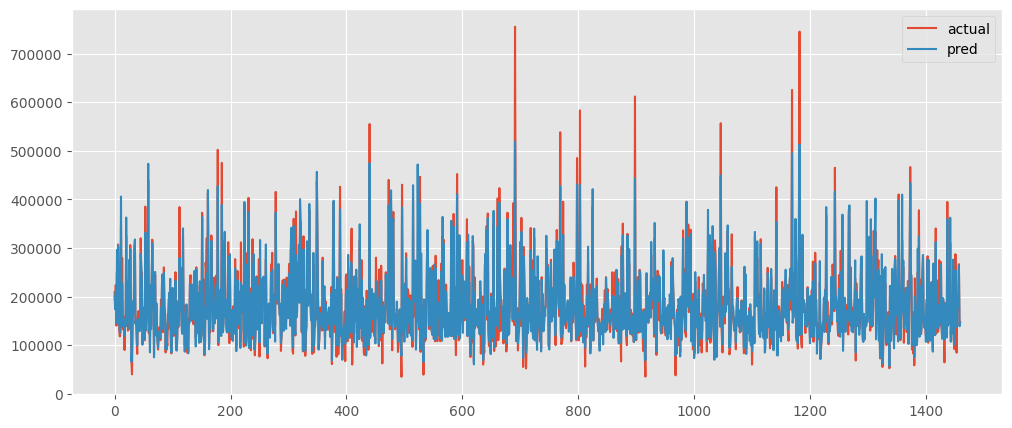

In [12]:
# 予測と実際の誤差
actual_pred_df.plot(figsize=(12,5))

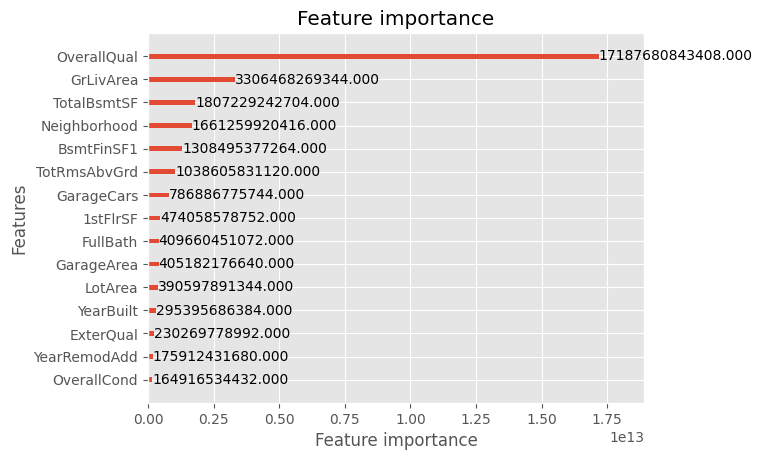

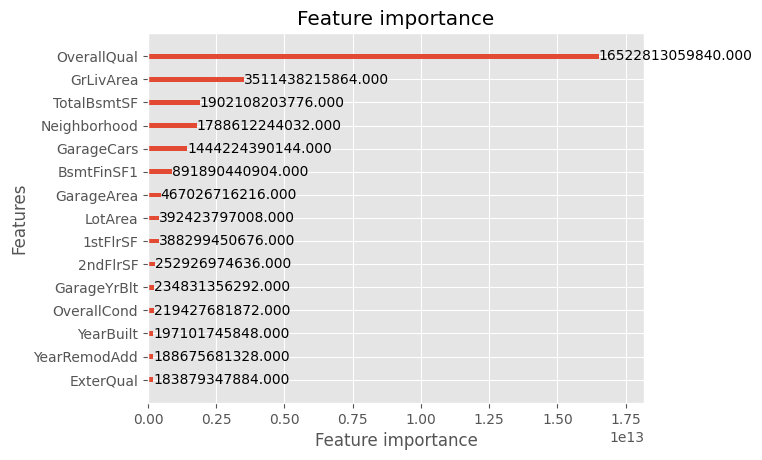

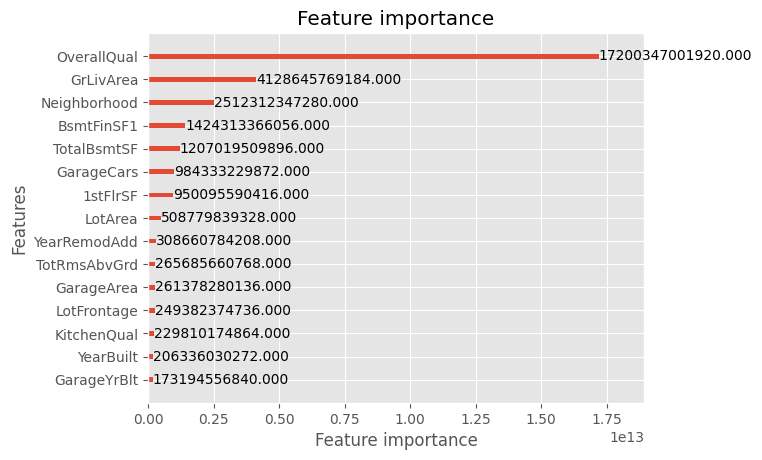

In [13]:
for model in models:
    lgb.plot_importance(model, importance_type = "gain", max_num_features = 15)

#### 

In [14]:
# 目的変数の分布がポアソン分布のためLOGを取る
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis = 1)
train_Y = train_df_le["SalePrice_log"]

/tmp/ipykernel_19/3863133484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])


In [15]:
import lightgbm as lgb
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference = lgb_train)
    
    model_lgb = lgb.train(lgbm_params,
                         lgb_train,
                         valid_sets = lgb_eval,
                         num_boost_round = 100,
                         early_stopping_rounds = 20,
                          verbose_eval = 10,
                         )
    
    y_pred = model_lgb.predict(X_valid, num_iteration = model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in 

[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2963
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Info] Start training from score 12.017607
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0436707
[20]	valid_0's l2: 0.0222385
[30]	valid_0's l2: 0.0180434
[40]	valid_0's l2: 0.016907
[50]	valid_0's l2: 0.0165714
[60]	valid_0's l2: 0.0163693
[70]	valid_0's l2: 0.0162283
[80]	valid_0's l2: 0.0161985
[90]	valid_0's l2: 0.0160713
[100]	valid_0's l2: 0.0161346
Did not meet early stopping. Best iteration is:
[90]	valid_0's l2: 0.0160713
0.126772761834610

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in 

[20]	valid_0's l2: 0.0275751
[30]	valid_0's l2: 0.0227031
[40]	valid_0's l2: 0.0212778
[50]	valid_0's l2: 0.0206045
[60]	valid_0's l2: 0.0203294
[70]	valid_0's l2: 0.0203205
[80]	valid_0's l2: 0.0202362
[90]	valid_0's l2: 0.0200549
[100]	valid_0's l2: 0.0200203
Did not meet early stopping. Best iteration is:
[96]	valid_0's l2: 0.0200058
0.14144187593293361
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3005
[LightGBM] [Info] Number of data points in the train set: 974, number of used features: 75
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Info] Start training from score 12.028565
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0390

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in 

[20]	valid_0's l2: 0.0212181
[30]	valid_0's l2: 0.0176641
[40]	valid_0's l2: 0.0167935
[50]	valid_0's l2: 0.016452
[60]	valid_0's l2: 0.0162947
[70]	valid_0's l2: 0.0161933
[80]	valid_0's l2: 0.0162265
[90]	valid_0's l2: 0.0162094
Early stopping, best iteration is:
[72]	valid_0's l2: 0.0161708
0.1271643059371225


In [16]:
sum(rmses)/len(rmses)

0.13179298123488878

In [17]:
# 説明変数の前処理
all_df = pd.concat([train_df, test_df], sort = False).reset_index(drop=True)

In [18]:
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [19]:
# 欠損値上位40の確認
all_df.isnull().sum().sort_values(ascending=False).head(40)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
MasVnrType       1766
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageYrBlt       159
GarageFinish      159
GarageQual        159
GarageCond        159
GarageType        157
BsmtExposure       82
BsmtCond           82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrArea         23
MSZoning            4
Functional          2
BsmtFullBath        2
Utilities           2
BsmtHalfBath        2
Electrical          1
TotalBsmtSF         1
BsmtUnfSF           1
KitchenQual         1
BsmtFinSF2          1
BsmtFinSF1          1
SaleType            1
GarageCars          1
Exterior2nd         1
Exterior1st         1
GarageArea          1
YrSold              0
Fireplaces          0
MoSold              0
MiscVal             0
SaleCondition       0
dtype: int64

In [20]:
# まとめて処理
HighFacility_col = ["PoolQC", "MiscFeature", "Alley"]
for col in HighFacility_col:
    if all_df[col].dtype == "object":
        if len(all_df[all_df[col].isnull()]) > 0:
            all_df.loc[~all_df[col].isnull(), col] = 1
            all_df.loc[all_df[col].isnull(), col] = 0

In [21]:
all_df["hasHighFacility"] = all_df["PoolQC"] + all_df["MiscFeature"] + all_df["Alley"]

all_df["hasHighFacility"] = all_df["hasHighFacility"].astype(int)

all_df = all_df.drop(["PoolQC", "MiscFeature", "Alley"], axis = 1)

In [22]:
# 外れ値の除外
# 数値型のカラムの抜き出し
train_df_num = train_df.select_dtypes(include=[np.number])

# 比例尺度でない
nonratio_features = ["Id", "MSSubClass", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAd,"\
                    "MoSold", "YrSold"]

num_features = sorted(list(set(train_df_num) - set(nonratio_features)))

# setでkey(column)を括ることができる
num_features

# columnsを差分する
train_df_num_rs = train_df_num[num_features]

In [23]:
# 統計量75%以上が0
for col in num_features:
    if train_df_num_rs.describe()[col]["75%"] == 0:
        print(col, len(train_df_num_rs[train_df_num_rs[col] == 0]))

3SsnPorch 1436
BsmtFinSF2 1293
BsmtHalfBath 1378
EnclosedPorch 1252
LowQualFinSF 1434
MiscVal 1408
PoolArea 1453
ScreenPorch 1344


In [24]:
# NaN以外の値を持つ変数の数
for col in num_features:
    if train_df_num_rs[col].nunique() < 15:
        print(col, train_df_num_rs[col].nunique())

BedroomAbvGr 8
BsmtFullBath 4
BsmtHalfBath 3
Fireplaces 4
FullBath 4
GarageCars 5
HalfBath 3
KitchenAbvGr 4
MoSold 12
PoolArea 8
TotRmsAbvGrd 12


In [25]:
# 標準偏差±3より外れた値は除外したい
for col in num_features:
    
    tmp_df = train_df_num_rs[\
            (train_df_num_rs[col] > (train_df_num_rs[col].mean() + train_df_num_rs[col].std()*3)) | \
            (train_df_num_rs[col] < (train_df_num_rs[col].mean() - train_df_num_rs[col].std()*3))]
    
    print(col, len(tmp_df))   

all_df = all_df[(all_df["BsmtFinSF1"] < 2000) | \
               (all_df["SalePrice"].isnull())] 
all_df = all_df[(all_df["TotalBsmtSF"] < 3000) | \
               (all_df["SalePrice"].isnull())] 
all_df = all_df[(all_df["GrLivArea"] < 4500) | \
               (all_df["SalePrice"].isnull())] 
all_df = all_df[(all_df["1stFlrSF"] < 2500) | \
               (all_df["SalePrice"].isnull())] 
all_df = all_df[(all_df["LotArea"] < 100000) | \
               (all_df["SalePrice"].isnull())] 

1stFlrSF 12
2ndFlrSF 4
3SsnPorch 23
BedroomAbvGr 14
BsmtFinSF1 6
BsmtFinSF2 50
BsmtFullBath 16
BsmtHalfBath 82
BsmtUnfSF 11
EnclosedPorch 51
Fireplaces 5
FullBath 0
GarageArea 7
GarageCars 0
GarageYrBlt 1
GrLivArea 16
HalfBath 12
KitchenAbvGr 68
LotArea 13
LotFrontage 12
LowQualFinSF 20
MasVnrArea 32
MiscVal 8
MoSold 0
OpenPorchSF 27
PoolArea 7
SalePrice 22
ScreenPorch 55
TotRmsAbvGrd 12
TotalBsmtSF 10
WoodDeckSF 22
YearRemodAdd 0


In [26]:
# 前処理したデータでRMSEを計算する
categories = categories.drop(["PoolQC", "MiscFeature", "Alley"])

In [27]:
# カテゴリ変数の変換
for cat in categories:
    le = LabelEncoder()
    print(cat)
    
    all_df[cat].fillna("missing", inplace = True)
    le = le.fit(all_df[cat])
    
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
Fence
SaleType
SaleCondition


In [28]:
# エラー吐くので解決できず
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice", "SalePrice_log", "Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

/tmp/ipykernel_19/3589427824.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])


In [29]:
all_df[["YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold"]].describe()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,2904.000000,2904.000000,2745.000000,2904.000000
mean,1971.234504,1984.217975,1978.061202,2007.792011
std,30.319059,20.907346,25.600996,1.316366
min,1872.000000,1950.000000,1895.000000,2006.000000
25%,1953.000000,1965.000000,1960.000000,2007.000000
50%,1973.000000,1993.000000,1979.000000,2008.000000
75%,2001.000000,2004.000000,2002.000000,2009.000000
max,2010.000000,2010.000000,2207.000000,2010.000000


In [30]:
# 特徴量を追加
all_df["Age"] = all_df["YrSold"] - all_df["YearBuilt"]

In [31]:
import lightgbm as lgb
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference = lgb_train)
    
    model_lgb = lgb.train(lgbm_params,
                         lgb_train,
                         valid_sets = lgb_eval,
                         num_boost_round = 100,
                         early_stopping_rounds = 20,
                          verbose_eval = 10,
                         )
    
    y_pred = model_lgb.predict(X_valid, num_iteration = model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred
    
sum(rmses)/len(rmses)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in 

[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2948
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 72
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0423077
[20]	valid_0's l2: 0.0217695
[30]	valid_0's l2: 0.017511
[40]	valid_0's l2: 0.0162447
[50]	valid_0's l2: 0.0161528
[60]	valid_0's l2: 0.0160055
[70]	valid_0's l2: 0.0160335
[80]	valid_0's l2: 0.0160276
[90]	valid_0's l2: 0.0160347
[100]	valid_0's l2: 0.0160414
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 0.0159996
0.126489534946556

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in 

[10]	valid_0's l2: 0.0469324
[20]	valid_0's l2: 0.0267978
[30]	valid_0's l2: 0.0219512
[40]	valid_0's l2: 0.0202687
[50]	valid_0's l2: 0.0195593
[60]	valid_0's l2: 0.0194735
[70]	valid_0's l2: 0.0193812
[80]	valid_0's l2: 0.0194739
[90]	valid_0's l2: 0.0194552
Early stopping, best iteration is:
[70]	valid_0's l2: 0.0193812
0.13921636560586953
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 964, number of used features: 73
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Info] Start training from score 12.021869
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0370497


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in 

[20]	valid_0's l2: 0.0195352
[30]	valid_0's l2: 0.016412
[40]	valid_0's l2: 0.0155942
[50]	valid_0's l2: 0.0151884
[60]	valid_0's l2: 0.0151752
[70]	valid_0's l2: 0.0153067
Early stopping, best iteration is:
[58]	valid_0's l2: 0.0151274
0.12299343081439215


0.12956644378893936

In [32]:
sum(rmses)/len(rmses)

0.12956644378893936

In [33]:
# 広さ関係の統計量
all_df[["LotArea", "MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",\
       "GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF", \
       "EnclosedPorch", "3SsnPorch", "ScreenPorch", \
       "PoolArea", "LotFrontage"]].describe()

,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,LotFrontage
count,2904.000000,2882.000000,2903.000000,2903.000000,2904.000000,2904.000000,2904.000000,2904.000000,2903.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2425.000000
mean,9912.604683,101.191187,559.850499,1043.794006,1152.707300,336.355372,4.718664,1493.781336,471.632794,93.265840,47.226584,22.988636,2.615702,16.086777,1.907025,69.071340
std,5178.128224,177.804595,438.438879,420.008348,377.291394,427.355787,46.515308,491.149725,214.551791,125.855568,67.195477,64.055325,25.252464,56.245764,33.082892,22.662001
min,1300.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,7448.250000,0.000000,220.000000,791.500000,875.750000,0.000000,0.000000,1124.000000,319.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000
50%,9422.000000,0.000000,467.000000,988.000000,1080.000000,0.000000,0.000000,1441.000000,478.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,68.000000
75%,11503.000000,164.000000,802.500000,1296.000000,1381.250000,704.000000,0.000000,1739.250000,576.000000,168.000000,69.250000,0.000000,0.000000,0.000000,0.000000,80.000000
max,70761.000000,1600.000000,2336.000000,5095.000000,5095.000000,1872.000000,1064.000000,5095.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,313.000000


In [34]:
# 広さの変数追加
all_df["TotalSF"] = all_df["TotalBsmtSF"] + all_df["1stFlrSF"] + all_df["2ndFlrSF"]
all_df["Total_Bathrooms"] = all_df["FullBath"] + all_df["HalfBath"] + \
                            all_df["BsmtFullBath"] + all_df["BsmtHalfBath"]

In [35]:
# Porchの特徴量
all_df["Total_PorchSF"] = all_df["WoodDeckSF"] + all_df["OpenPorchSF"] + \
                            all_df["EnclosedPorch"] + all_df["3SsnPorch"] + \
                            all_df["ScreenPorch"]

In [36]:
#Porchがあるかないかで1か0に分類
all_df["hasPorch"] = all_df["Total_PorchSF"].apply(lambda x: 1 if x > 0 else 0)
all_df = all_df.drop("Total_PorchSF", axis = 1)

In [37]:
import lightgbm as lgb
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference = lgb_train)
    
    model_lgb = lgb.train(lgbm_params,
                         lgb_train,
                         valid_sets = lgb_eval,
                         num_boost_round = 100,
                         early_stopping_rounds = 20,
                          verbose_eval = 10,
                         )
    
    y_pred = model_lgb.predict(X_valid, num_iteration = model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in 

[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2948
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 72
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0423077
[20]	valid_0's l2: 0.0217695
[30]	valid_0's l2: 0.017511
[40]	valid_0's l2: 0.0162447
[50]	valid_0's l2: 0.0161528
[60]	valid_0's l2: 0.0160055
[70]	valid_0's l2: 0.0160335
[80]	valid_0's l2: 0.0160276
[90]	valid_0's l2: 0.0160347
[100]	valid_0's l2: 0.0160414
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 0.0159996
0.126489534946556

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in 

[20]	valid_0's l2: 0.0267978
[30]	valid_0's l2: 0.0219512
[40]	valid_0's l2: 0.0202687
[50]	valid_0's l2: 0.0195593
[60]	valid_0's l2: 0.0194735
[70]	valid_0's l2: 0.0193812
[80]	valid_0's l2: 0.0194739
[90]	valid_0's l2: 0.0194552
Early stopping, best iteration is:
[70]	valid_0's l2: 0.0193812
0.13921636560586953
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2987
[LightGBM] [Info] Number of data points in the train set: 964, number of used features: 73
[LightGBM] [Warning] Unknown parameter: objectie
[LightGBM] [Info] Start training from score 12.021869
Training until validation scores don't improve for 20 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in 

[10]	valid_0's l2: 0.0370497
[20]	valid_0's l2: 0.0195352
[30]	valid_0's l2: 0.016412
[40]	valid_0's l2: 0.0155942
[50]	valid_0's l2: 0.0151884
[60]	valid_0's l2: 0.0151752
[70]	valid_0's l2: 0.0153067
Early stopping, best iteration is:
[58]	valid_0's l2: 0.0151274
0.12299343081439215


In [38]:
sum(rmses)/len(rmses)

0.12956644378893936

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, \
                                test_size = 0.2, random_state=1234, shuffle=False, stratify=None)

In [40]:
def objective(trial):
    params = {
        "objective": "regression",
        "random_seed": 1234,
        "n_estimators": 1000,
        "num_leaves": trial.suggest_int("num_leaves", 4, 64),
        "max_bin": trial.suggest_int("max_bin", 50, 200),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 16),
        "min_sum_hessian_in_leaf": trial.suggest_int("min_sum_hessian_in_leaf", 1, 10),
    }
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb.train)
    
    model_lgb = lgb.train(params, lgb_train, valid_sets=lgb_eval,
                         num_boost_round=100, early_stopping_rounds=20, verbose_eval=10)
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    return score

In [41]:
import optuna
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=50)
study.best_params

[I 2023-11-25 23:16:54,323] A new study created in memory with name: no-name-4554938a-4f00-4628-9723-2c6d0c634614
/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2539
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0365395
[20]	valid_0's l2: 0.0199143
[30]	valid_0's l2: 0.0165795
[40]	valid_0's l2: 0.0159637
[50]	valid_0's l2: 0.015515
[60]	valid_0's l2: 0.0151314
[70]	valid_0's l2: 0.0150653
[80]	valid_0's l2: 0.015056
[90]	valid_0's l2: 0.0150955
[100]	valid_0's l2: 0.0150178
[110]	valid_0's l2: 0.0149036
[120]	valid_0's l2: 0.0149718
[130]	valid_0's l2: 0.0149751
Early stopping, best iteration is:
[112]	valid_0's l2: 0.0148806


[I 2023-11-25 23:16:56,475] Trial 0 finished with value: 0.12198611685405686 and parameters: {'num_leaves': 37, 'max_bin': 157, 'bagging_fraction': 0.7013816880358219, 'bagging_freq': 6, 'feature_frction': 0.6118273996694523, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 0 with value: 0.12198611685405686.
/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: F

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2793
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2023-11-25 23:16:57,919] Trial 1 finished with value: 0.12201526276254611 and parameters: {'num_leaves': 58, 'max_bin': 195, 'bagging_fraction': 0.5917207594128888, 'bagging_freq': 8, 'feature_frction': 0.6644474598764523, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.12198611685405686.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[57]	valid_0's l2: 0.0148877


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1436
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0456486
[20]	valid_0's l2: 0.0249611
[30]	valid_0's l2: 0.0187009
[40]	valid_0's l2: 0.0166607
[50]	valid_0's l2: 0.0157612
[60]	valid_0's l2: 0.0149016
[70]	valid_0's l2: 0.0145017
[80]	valid_0's l2: 0.0142615
[90]	valid_0's l2: 0.0143416
[100]	valid_0's l2: 0.0143892


[I 2023-11-25 23:16:58,767] Trial 2 finished with value: 0.1189754872821113 and parameters: {'num_leaves': 8, 'max_bin': 63, 'bagging_fraction': 0.4101091987201629, 'bagging_freq': 9, 'feature_frction': 0.7890783754749253, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 10}. Best is trial 2 with value: 0.1189754872821113.


[110]	valid_0's l2: 0.0145714
Early stopping, best iteration is:
[94]	valid_0's l2: 0.0141552
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2126
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 75
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[10]	valid_0's l2: 0.0368967
[20]	valid_0's l2: 0.0208998
[30]	valid_0's l2: 0.0176208
[40]	valid_0's l2: 0.0168336
[50]	valid_0's l2: 0.0167967
[60]	valid_0's l2: 0.0168069
[70]	valid_0's l2: 0.016685
[80]	valid_0's l2: 0.0165206
[90]	valid_0's l2: 0.0165508
[100]	valid_0's l2: 0.0165113
[110]	valid_0's l2: 0.0164663
[120]	valid_0's l2: 0.0163909
[130]	valid_0's l2: 0.0164446
[140]	valid_0's l2: 0.0163763


[I 2023-11-25 23:17:02,161] Trial 3 finished with value: 0.12794168983286935 and parameters: {'num_leaves': 52, 'max_bin': 119, 'bagging_fraction': 0.7902645881432278, 'bagging_freq': 2, 'feature_frction': 0.7199605106637619, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 2 with value: 0.1189754872821113.


[150]	valid_0's l2: 0.0164358
Early stopping, best iteration is:
[138]	valid_0's l2: 0.0163691


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2047
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0356528
[20]	valid_0's l2: 0.018417
[30]	valid_0's l2: 0.0149862
[40]	valid_0's l2: 0.0146439
[50]	valid_0's l2: 0.0140715
[60]	valid_0's l2: 0.013724
[70]	valid_0's l2: 0.0138231


[I 2023-11-25 23:17:03,303] Trial 4 finished with value: 0.11693947274750345 and parameters: {'num_leaves': 35, 'max_bin': 112, 'bagging_fraction': 0.5322778060523135, 'bagging_freq': 8, 'feature_frction': 0.6280751661082743, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.11693947274750345.


[80]	valid_0's l2: 0.0141316
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0136748
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2375
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[10]	valid_0's l2: 0.0356799
[20]	valid_0's l2: 0.0200605
[30]	valid_0's l2: 0.0175323
[40]	valid_0's l2: 0.0175265


[I 2023-11-25 23:17:04,230] Trial 5 finished with value: 0.13214638083520708 and parameters: {'num_leaves': 41, 'max_bin': 142, 'bagging_fraction': 0.7084669984373785, 'bagging_freq': 10, 'feature_frction': 0.7409101495517417, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 4 with value: 0.11693947274750345.


[50]	valid_0's l2: 0.017607
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0174627
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 75
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[10]	valid_0's l2: 0.0368983
[20]	valid_0's l2: 0.0201751
[30]	valid_0's l2: 0.0177145
[40]	valid_0's l2: 0.0173642
[50]	valid_0's l2: 0.0171239
[60]	valid_0's l2: 0.0171068


[I 2023-11-25 23:17:05,638] Trial 6 finished with value: 0.1304396068052608 and parameters: {'num_leaves': 46, 'max_bin': 59, 'bagging_fraction': 0.7333833577228339, 'bagging_freq': 7, 'feature_frction': 0.5051912805369205, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11693947274750345.


Early stopping, best iteration is:
[45]	valid_0's l2: 0.0170145
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0365842


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[20]	valid_0's l2: 0.0194088
[30]	valid_0's l2: 0.0159541
[40]	valid_0's l2: 0.0152578
[50]	valid_0's l2: 0.0150358
[60]	valid_0's l2: 0.0145383
[70]	valid_0's l2: 0.0146189
[80]	valid_0's l2: 0.0145238
[90]	valid_0's l2: 0.0146111


[I 2023-11-25 23:17:07,036] Trial 7 finished with value: 0.12028418959328227 and parameters: {'num_leaves': 26, 'max_bin': 136, 'bagging_fraction': 0.6193007567311601, 'bagging_freq': 10, 'feature_frction': 0.45102240537401406, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 4 with value: 0.11693947274750345.


[100]	valid_0's l2: 0.0147466
Early stopping, best iteration is:
[85]	valid_0's l2: 0.0144683
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1774
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 75
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[10]	valid_0's l2: 0.0371304
[20]	valid_0's l2: 0.0201557
[30]	valid_0's l2: 0.0164078
[40]	valid_0's l2: 0.0155903
[50]	valid_0's l2: 0.0149884
[60]	valid_0's l2: 0.0144848
[70]	valid_0's l2: 0.014479
[80]	valid_0's l2: 0.014577


[I 2023-11-25 23:17:08,863] Trial 8 finished with value: 0.1198796569928548 and parameters: {'num_leaves': 43, 'max_bin': 88, 'bagging_fraction': 0.6331553864281532, 'bagging_freq': 3, 'feature_frction': 0.4794847918227599, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11693947274750345.


Early stopping, best iteration is:
[65]	valid_0's l2: 0.0143711
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1652
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0406093
[20]	valid_0's l2: 0.0221461


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[30]	valid_0's l2: 0.0168028
[40]	valid_0's l2: 0.0150514
[50]	valid_0's l2: 0.0144639
[60]	valid_0's l2: 0.0140595


[I 2023-11-25 23:17:09,461] Trial 9 finished with value: 0.1180173504968219 and parameters: {'num_leaves': 12, 'max_bin': 79, 'bagging_fraction': 0.5843625853304821, 'bagging_freq': 9, 'feature_frction': 0.44855063789653066, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.11693947274750345.


[70]	valid_0's l2: 0.0139281
[80]	valid_0's l2: 0.014163
[90]	valid_0's l2: 0.0142574
Early stopping, best iteration is:
[70]	valid_0's l2: 0.0139281
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 76
[LightGBM] [Info] Start training from score 12.015333


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0345549
[20]	valid_0's l2: 0.0195464
[30]	valid_0's l2: 0.0171152
[40]	valid_0's l2: 0.0164154
[50]	valid_0's l2: 0.0161242
[60]	valid_0's l2: 0.0160286
[70]	valid_0's l2: 0.0159944
[80]	valid_0's l2: 0.0159764
[90]	valid_0's l2: 0.0159877


[I 2023-11-25 23:17:12,097] Trial 10 finished with value: 0.12626754327462872 and parameters: {'num_leaves': 63, 'max_bin': 120, 'bagging_fraction': 0.8883805440951686, 'bagging_freq': 7, 'feature_frction': 0.7696317896991509, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 4 with value: 0.11693947274750345.


[100]	valid_0's l2: 0.0159958
Early stopping, best iteration is:
[85]	valid_0's l2: 0.0159435
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1854
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 76


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0420811
[20]	valid_0's l2: 0.0229337
[30]	valid_0's l2: 0.0177555
[40]	valid_0's l2: 0.0163059
[50]	valid_0's l2: 0.0153191
[60]	valid_0's l2: 0.0151592
[70]	valid_0's l2: 0.0149802


[I 2023-11-25 23:17:12,728] Trial 11 finished with value: 0.12103073798371562 and parameters: {'num_leaves': 11, 'max_bin': 94, 'bagging_fraction': 0.45936385947712205, 'bagging_freq': 4, 'feature_frction': 0.607131497257335, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11693947274750345.


[80]	valid_0's l2: 0.0146786
[90]	valid_0's l2: 0.0149273
[100]	valid_0's l2: 0.0151662
Early stopping, best iteration is:
[83]	valid_0's l2: 0.0146484
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1798
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's l2: 0.0351408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's l2: 0.0189486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's l2: 0.0160624
[40]	valid_0's l2: 0.0152699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's l2: 0.0149994
[60]	valid_0's l2: 0.0148308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's l2: 0.0147918


[I 2023-11-25 23:17:13,906] Trial 12 finished with value: 0.12161756193154731 and parameters: {'num_leaves': 38, 'max_bin': 90, 'bagging_fraction': 0.6616240267333499, 'bagging_freq': 1, 'feature_frction': 0.6879732477780897, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11693947274750345.


[80]	valid_0's l2: 0.0148811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[69]	valid_0's l2: 0.0147908
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1518
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0365685
[20]	valid_0's l2: 0.019585
[30]	valid_0's l2: 0.0162914
[40]	valid_0's l2: 0.0155566
[50]	valid_0's l2: 0.0154046
[60]	valid_0's l2: 0.0152142
[70]	valid_0's l2: 0.0152609


[I 2023-11-25 23:17:15,505] Trial 13 finished with value: 0.12275702014467345 and parameters: {'num_leaves': 44, 'max_bin': 69, 'bagging_fraction': 0.7581636020592828, 'bagging_freq': 3, 'feature_frction': 0.49159568100355844, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.11693947274750345.


[80]	valid_0's l2: 0.015247
Early stopping, best iteration is:
[63]	valid_0's l2: 0.0150693
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1235
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's l2: 0.0370657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2023-11-25 23:17:16,764] Trial 14 finished with value: 0.12403377390962647 and parameters: {'num_leaves': 54, 'max_bin': 50, 'bagging_fraction': 0.7389082683981151, 'bagging_freq': 3, 'feature_frction': 0.7675970110612975, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 3}. Best is trial 4 with value: 0.11693947274750345.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[66]	valid_0's l2: 0.0153844
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2342
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[10]	valid_0's l2: 0.035006
[20]	valid_0's l2: 0.0194397
[30]	valid_0's l2: 0.0166387
[40]	valid_0's l2: 0.0159551
[50]	valid_0's l2: 0.0156856
[60]	valid_0's l2: 0.0154644
[70]	valid_0's l2: 0.0153788
[80]	valid_0's l2: 0.0153473


[I 2023-11-25 23:17:18,327] Trial 15 finished with value: 0.12364070078080504 and parameters: {'num_leaves': 39, 'max_bin': 139, 'bagging_fraction': 0.6861259528954367, 'bagging_freq': 3, 'feature_frction': 0.8763745057584925, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.11693947274750345.


[90]	valid_0's l2: 0.015383
Early stopping, best iteration is:
[78]	valid_0's l2: 0.015287
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0342834
[20]	valid_0's l2: 0.0182234
[30]	valid_0's l2: 0.0155617
[40]	valid_0's l2: 0.0150558
[50]	valid_0's l2: 0.0149556
[60]	valid_0's l2: 0.0149036
[70]	valid_0's l2: 0.0149215


[I 2023-11-25 23:17:19,759] Trial 16 finished with value: 0.12189449770260767 and parameters: {'num_leaves': 46, 'max_bin': 94, 'bagging_fraction': 0.8068989098512387, 'bagging_freq': 4, 'feature_frction': 0.8405515985555808, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.11693947274750345.


[80]	valid_0's l2: 0.0150583
Early stopping, best iteration is:
[64]	valid_0's l2: 0.0148583
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2559
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[10]	valid_0's l2: 0.0352461
[20]	valid_0's l2: 0.0200052
[30]	valid_0's l2: 0.017724
[40]	valid_0's l2: 0.0178512


[I 2023-11-25 23:17:20,680] Trial 17 finished with value: 0.13301809707507994 and parameters: {'num_leaves': 46, 'max_bin': 159, 'bagging_fraction': 0.6506621909633512, 'bagging_freq': 10, 'feature_frction': 0.7219950996148188, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11693947274750345.


[50]	valid_0's l2: 0.0179842
Early stopping, best iteration is:
[33]	valid_0's l2: 0.0176938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1862
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0509951
[20]	valid_0's l2: 0.0290771
[30]	valid_0's l2: 0.0215152


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[40]	valid_0's l2: 0.0184847
[50]	valid_0's l2: 0.0170129
[60]	valid_0's l2: 0.0161937
[70]	valid_0's l2: 0.0157987
[80]	valid_0's l2: 0.0153222
[90]	valid_0's l2: 0.0152359
[100]	valid_0's l2: 0.0150787
[110]	valid_0's l2: 0.0147373
[120]	valid_0's l2: 0.0144772


[I 2023-11-25 23:17:21,124] Trial 18 finished with value: 0.1201250719603509 and parameters: {'num_leaves': 5, 'max_bin': 95, 'bagging_fraction': 0.7300867687463426, 'bagging_freq': 3, 'feature_frction': 0.7090077144994208, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 2}. Best is trial 4 with value: 0.11693947274750345.


[130]	valid_0's l2: 0.0144683
[140]	valid_0's l2: 0.0145403
Early stopping, best iteration is:
[127]	valid_0's l2: 0.01443
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[10]	valid_0's l2: 0.0367951
[20]	valid_0's l2: 0.0192291
[30]	valid_0's l2: 0.0155556


[I 2023-11-25 23:17:21,701] Trial 19 finished with value: 0.12111836628030476 and parameters: {'num_leaves': 22, 'max_bin': 136, 'bagging_fraction': 0.6954363806240866, 'bagging_freq': 6, 'feature_frction': 0.7266004099285668, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 4 with value: 0.11693947274750345.


[40]	valid_0's l2: 0.014727
[50]	valid_0's l2: 0.0147774
Early stopping, best iteration is:
[39]	valid_0's l2: 0.0146697


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1964
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2023-11-25 23:17:22,900] Trial 20 finished with value: 0.12497155478041522 and parameters: {'num_leaves': 58, 'max_bin': 105, 'bagging_fraction': 0.6179324626328134, 'bagging_freq': 9, 'feature_frction': 0.8030969945230428, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 2}. Best is trial 4 with value: 0.11693947274750345.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[57]	valid_0's l2: 0.0156179
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2541
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 75
[LightGBM] [Info] Start training from score 12.015333
Tr

/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[10]	valid_0's l2: 0.0344086
[20]	valid_0's l2: 0.0200029
[30]	valid_0's l2: 0.01804
[40]	valid_0's l2: 0.0178573
[50]	valid_0's l2: 0.017578
[60]	valid_0's l2: 0.0175896
[70]	valid_0's l2: 0.0175015
[80]	valid_0's l2: 0.0174485
[90]	valid_0's l2: 0.0174525
[100]	valid_0's l2: 0.0174113
[110]	valid_0's l2: 0.0174107


[I 2023-11-25 23:17:25,906] Trial 21 finished with value: 0.13179235059110586 and parameters: {'num_leaves': 60, 'max_bin': 157, 'bagging_fraction': 0.8994235032839333, 'bagging_freq': 2, 'feature_frction': 0.8340630286841071, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11693947274750345.


[120]	valid_0's l2: 0.0174491
Early stopping, best iteration is:
[104]	valid_0's l2: 0.0173692
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2730
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 75
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[10]	valid_0's l2: 0.0426202
[20]	valid_0's l2: 0.0224499
[30]	valid_0's l2: 0.0173456
[40]	valid_0's l2: 0.015762
[50]	valid_0's l2: 0.0152371
[60]	valid_0's l2: 0.0147571
[70]	valid_0's l2: 0.0144194
[80]	valid_0's l2: 0.0142927
[90]	valid_0's l2: 0.0142818
[100]	valid_0's l2: 0.014367
[110]	valid_0's l2: 0.0142868
[120]	valid_0's l2: 0.0143299
Early stopping, best iteration is:
[107]	valid_0's l2: 0.0142413


[I 2023-11-25 23:17:26,667] Trial 22 finished with value: 0.11933710362385586 and parameters: {'num_leaves': 11, 'max_bin': 178, 'bagging_fraction': 0.8036594793625054, 'bagging_freq': 6, 'feature_frction': 0.6035916486129999, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11693947274750345.
/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: F

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 76
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0373595
[20]	valid_0's l2: 0.0215309
[30]	valid_0's l2: 0.0181154
[40]	valid_0's l2: 0.0173608
[50]	valid_0's l2: 0.01719
[60]	valid_0's l2: 0.0169337
[70]	valid_0's l2: 0.0168434


[I 2023-11-25 23:17:27,950] Trial 23 finished with value: 0.12955713992896506 and parameters: {'num_leaves': 31, 'max_bin': 159, 'bagging_fraction': 0.8331911629643146, 'bagging_freq': 10, 'feature_frction': 0.8279016711963055, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11693947274750345.


[80]	valid_0's l2: 0.0168707
[90]	valid_0's l2: 0.0169311
Early stopping, best iteration is:
[74]	valid_0's l2: 0.016785


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1602
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 76
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.035646
[20]	valid_0's l2: 0.0201726
[30]	valid_0's l2: 0.0174352
[40]	valid_0's l2: 0.0165984
[50]	valid_0's l2: 0.0164382
[60]	valid_0's l2: 0.0160802
[70]	valid_0's l2: 0.0160549
[80]	valid_0's l2: 0.0161246


[I 2023-11-25 23:17:30,512] Trial 24 finished with value: 0.12670778717726922 and parameters: {'num_leaves': 48, 'max_bin': 75, 'bagging_fraction': 0.6605183031020647, 'bagging_freq': 1, 'feature_frction': 0.49999826244820006, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 4 with value: 0.11693947274750345.


[90]	valid_0's l2: 0.0161077
Early stopping, best iteration is:
[70]	valid_0's l2: 0.0160549
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1946
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 75
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.041734


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[20]	valid_0's l2: 0.0217833
[30]	valid_0's l2: 0.0176064
[40]	valid_0's l2: 0.016117
[50]	valid_0's l2: 0.0154815
[60]	valid_0's l2: 0.0151767
[70]	valid_0's l2: 0.0153915


[I 2023-11-25 23:17:31,310] Trial 25 finished with value: 0.12318416548463373 and parameters: {'num_leaves': 17, 'max_bin': 102, 'bagging_fraction': 0.8640406467327955, 'bagging_freq': 8, 'feature_frction': 0.41591946476565395, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11693947274750345.


[80]	valid_0's l2: 0.0152887
Early stopping, best iteration is:
[66]	valid_0's l2: 0.0151743
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1732
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[10]	valid_0's l2: 0.0355227
[20]	valid_0's l2: 0.0198784
[30]	valid_0's l2: 0.0166301
[40]	valid_0's l2: 0.0155681
[50]	valid_0's l2: 0.0152399
[60]	valid_0's l2: 0.0153424
[70]	valid_0's l2: 0.0151424
[80]	valid_0's l2: 0.0153763


[I 2023-11-25 23:17:32,835] Trial 26 finished with value: 0.12305428475222327 and parameters: {'num_leaves': 39, 'max_bin': 85, 'bagging_fraction': 0.867106998962397, 'bagging_freq': 7, 'feature_frction': 0.6678164015124792, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 8}. Best is trial 4 with value: 0.11693947274750345.


[90]	valid_0's l2: 0.0153847
Early stopping, best iteration is:
[70]	valid_0's l2: 0.0151424
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2025
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.038974


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[20]	valid_0's l2: 0.020945
[30]	valid_0's l2: 0.0165886
[40]	valid_0's l2: 0.0149808
[50]	valid_0's l2: 0.0148647
[60]	valid_0's l2: 0.0148696
[70]	valid_0's l2: 0.0149995
Early stopping, best iteration is:
[52]	valid_0's l2: 0.0147521


[I 2023-11-25 23:17:33,542] Trial 27 finished with value: 0.12145805301070497 and parameters: {'num_leaves': 23, 'max_bin': 110, 'bagging_fraction': 0.5049218744875611, 'bagging_freq': 2, 'feature_frction': 0.8721861949919668, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 5}. Best is trial 4 with value: 0.11693947274750345.
/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1772
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0403979
[20]	valid_0's l2: 0.0219908
[30]	valid_0's l2: 0.0176889
[40]	valid_0's l2: 0.0154959
[50]	valid_0's l2: 0.0150046


[I 2023-11-25 23:17:34,181] Trial 28 finished with value: 0.1223179701635193 and parameters: {'num_leaves': 17, 'max_bin': 88, 'bagging_fraction': 0.42901458016193783, 'bagging_freq': 5, 'feature_frction': 0.5558979409970513, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11693947274750345.


[60]	valid_0's l2: 0.0151055
[70]	valid_0's l2: 0.0157814
Early stopping, best iteration is:
[51]	valid_0's l2: 0.0149617
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[10]	valid_0's l2: 0.0395652
[20]	valid_0's l2: 0.0221016
[30]	valid_0's l2: 0.0173693
[40]	valid_0's l2: 0.0158156
[50]	valid_0's l2: 0.0147451
[60]	valid_0's l2: 0.0143422
[70]	valid_0's l2: 0.0145523
Early stopping, best iteration is:
[59]	valid_0's l2: 0.0143266


[I 2023-11-25 23:17:34,763] Trial 29 finished with value: 0.1196936288225479 and parameters: {'num_leaves': 14, 'max_bin': 53, 'bagging_fraction': 0.4336248157316243, 'bagging_freq': 7, 'feature_frction': 0.6268484222780226, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.11693947274750345.
/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Fo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1690
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2023-11-25 23:17:36,798] Trial 30 finished with value: 0.12185441524664521 and parameters: {'num_leaves': 64, 'max_bin': 82, 'bagging_fraction': 0.7315391015500504, 'bagging_freq': 3, 'feature_frction': 0.41032549973286436, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11693947274750345.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's l2: 0.015189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[83]	valid_0's l2: 0.0148485
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[10]	valid_0's l2: 0.0362508
[20]	valid_0's l2: 0.0196705
[30]	valid_0's l2: 0.0169288
[40]	valid_0's l2: 0.0164935
[50]	valid_0's l2: 0.0161617
[60]	valid_0's l2: 0.0161997
[70]	valid_0's l2: 0.0160211
[80]	valid_0's l2: 0.016118
Early stopping, best iteration is:
[69]	valid_0's l2: 0.0159826


[I 2023-11-25 23:17:37,929] Trial 31 finished with value: 0.12642223600185792 and parameters: {'num_leaves': 27, 'max_bin': 138, 'bagging_fraction': 0.8155242276180952, 'bagging_freq': 7, 'feature_frction': 0.8363253277236977, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 8}. Best is trial 4 with value: 0.11693947274750345.
/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: F

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2779
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0381895
[20]	valid_0's l2: 0.0201475
[30]	valid_0's l2: 0.0162761
[40]	valid_0's l2: 0.0152479
[50]	valid_0's l2: 0.0150871
[60]	valid_0's l2: 0.0147753


[I 2023-11-25 23:17:38,578] Trial 32 finished with value: 0.12133216320597726 and parameters: {'num_leaves': 15, 'max_bin': 193, 'bagging_fraction': 0.7437441381939076, 'bagging_freq': 3, 'feature_frction': 0.8736852952444621, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 3}. Best is trial 4 with value: 0.11693947274750345.


[70]	valid_0's l2: 0.0149668
[80]	valid_0's l2: 0.0149232
Early stopping, best iteration is:
[66]	valid_0's l2: 0.0147215
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2222
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[10]	valid_0's l2: 0.0385616
[20]	valid_0's l2: 0.0211242
[30]	valid_0's l2: 0.0171746
[40]	valid_0's l2: 0.0158896
[50]	valid_0's l2: 0.0157102
[60]	valid_0's l2: 0.0148532


[I 2023-11-25 23:17:39,282] Trial 33 finished with value: 0.12149959074322875 and parameters: {'num_leaves': 17, 'max_bin': 128, 'bagging_fraction': 0.4128313590272658, 'bagging_freq': 3, 'feature_frction': 0.6123427343757532, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 4 with value: 0.11693947274750345.


[70]	valid_0's l2: 0.015033
[80]	valid_0's l2: 0.0150684
Early stopping, best iteration is:
[64]	valid_0's l2: 0.0147621
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2333
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 75
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[10]	valid_0's l2: 0.0385875
[20]	valid_0's l2: 0.0207105
[30]	valid_0's l2: 0.0168456
[40]	valid_0's l2: 0.01596
[50]	valid_0's l2: 0.0154929
[60]	valid_0's l2: 0.0152995
[70]	valid_0's l2: 0.0148113
[80]	valid_0's l2: 0.0148889
[90]	valid_0's l2: 0.0148793
Early stopping, best iteration is:
[72]	valid_0's l2: 0.014741


[I 2023-11-25 23:17:40,186] Trial 34 finished with value: 0.1214126469476969 and parameters: {'num_leaves': 20, 'max_bin': 138, 'bagging_fraction': 0.8319278029616157, 'bagging_freq': 2, 'feature_frction': 0.6586895535770572, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 8}. Best is trial 4 with value: 0.11693947274750345.
/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Fo

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0376027
[20]	valid_0's l2: 0.0201432
[30]	valid_0's l2: 0.0167926
[40]	valid_0's l2: 0.0155612
[50]	valid_0's l2: 0.015241
[60]	valid_0's l2: 0.0151633
[70]	valid_0's l2: 0.015223


[I 2023-11-25 23:17:41,227] Trial 35 finished with value: 0.1225323701892535 and parameters: {'num_leaves': 28, 'max_bin': 135, 'bagging_fraction': 0.49163991810703933, 'bagging_freq': 2, 'feature_frction': 0.6440281403244773, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 10}. Best is trial 4 with value: 0.11693947274750345.


Early stopping, best iteration is:
[56]	valid_0's l2: 0.0150142
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2598
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[10]	valid_0's l2: 0.0339959
[20]	valid_0's l2: 0.0186597
[30]	valid_0's l2: 0.0161327
[40]	valid_0's l2: 0.0157054
[50]	valid_0's l2: 0.015587
[60]	valid_0's l2: 0.0154562
[70]	valid_0's l2: 0.0154668
[80]	valid_0's l2: 0.0154705


[I 2023-11-25 23:17:42,810] Trial 36 finished with value: 0.12409524841401505 and parameters: {'num_leaves': 50, 'max_bin': 163, 'bagging_fraction': 0.8518598698729667, 'bagging_freq': 1, 'feature_frction': 0.6760962349612033, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 4 with value: 0.11693947274750345.


Early stopping, best iteration is:
[64]	valid_0's l2: 0.0153996
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0381403


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[20]	valid_0's l2: 0.0213689
[30]	valid_0's l2: 0.0174308
[40]	valid_0's l2: 0.0160584
[50]	valid_0's l2: 0.0156883
[60]	valid_0's l2: 0.0156595
[70]	valid_0's l2: 0.0155432
Early stopping, best iteration is:
[55]	valid_0's l2: 0.0154771


[I 2023-11-25 23:17:43,513] Trial 37 finished with value: 0.12440684175736301 and parameters: {'num_leaves': 21, 'max_bin': 86, 'bagging_fraction': 0.45014697113274893, 'bagging_freq': 1, 'feature_frction': 0.8647646583960953, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 8}. Best is trial 4 with value: 0.11693947274750345.
/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0380172
[20]	valid_0's l2: 0.0207075
[30]	valid_0's l2: 0.0172295
[40]	valid_0's l2: 0.0154514
[50]	valid_0's l2: 0.014864


[I 2023-11-25 23:17:44,206] Trial 38 finished with value: 0.12143592099415139 and parameters: {'num_leaves': 21, 'max_bin': 138, 'bagging_fraction': 0.4319776330604906, 'bagging_freq': 5, 'feature_frction': 0.8887475698722234, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11693947274750345.


[60]	valid_0's l2: 0.014831
[70]	valid_0's l2: 0.0154151
Early stopping, best iteration is:
[57]	valid_0's l2: 0.0147467
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1719
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0348229
[20]	valid_0's l2: 0.0191623
[30]	valid_0's l2: 0.0161356
[40]	valid_0's l2: 0.0156536
[50]	valid_0's l2: 0.0156743
[60]	valid_0's l2: 0.0155469
[70]	valid_0's l2: 0.0155122
[80]	valid_0's l2: 0.0155063


[I 2023-11-25 23:17:46,300] Trial 39 finished with value: 0.12432357554182503 and parameters: {'num_leaves': 62, 'max_bin': 84, 'bagging_fraction': 0.8746594112078407, 'bagging_freq': 10, 'feature_frction': 0.7996012936761958, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.11693947274750345.


[90]	valid_0's l2: 0.0156222
Early stopping, best iteration is:
[78]	valid_0's l2: 0.0154563


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2730
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 75
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0383089
[20]	valid_0's l2: 0.0207709
[30]	valid_0's l2: 0.0171154
[40]	valid_0's l2: 0.0160604
[50]	valid_0's l2: 0.0158106
[60]	valid_0's l2: 0.015324
[70]	valid_0's l2: 0.0152789
[80]	valid_0's l2: 0.0151293
[90]	valid_0's l2: 0.0151647


[I 2023-11-25 23:17:47,514] Trial 40 finished with value: 0.12281145671329718 and parameters: {'num_leaves': 21, 'max_bin': 178, 'bagging_fraction': 0.7089383459587619, 'bagging_freq': 1, 'feature_frction': 0.5736167589661099, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 4 with value: 0.11693947274750345.


[100]	valid_0's l2: 0.0152866
Early stopping, best iteration is:
[81]	valid_0's l2: 0.0150826
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2190
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[10]	valid_0's l2: 0.0382886
[20]	valid_0's l2: 0.02031
[30]	valid_0's l2: 0.0165785
[40]	valid_0's l2: 0.0154688
[50]	valid_0's l2: 0.0152008
[60]	valid_0's l2: 0.0151397


[I 2023-11-25 23:17:48,684] Trial 41 finished with value: 0.12295493356932888 and parameters: {'num_leaves': 33, 'max_bin': 125, 'bagging_fraction': 0.7197362581993618, 'bagging_freq': 4, 'feature_frction': 0.4684501358427995, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 2}. Best is trial 4 with value: 0.11693947274750345.


[70]	valid_0's l2: 0.0152077
Early stopping, best iteration is:
[55]	valid_0's l2: 0.0151179
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's l2: 0.0394816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2023-11-25 23:17:49,438] Trial 42 finished with value: 0.1219633520212273 and parameters: {'num_leaves': 35, 'max_bin': 83, 'bagging_fraction': 0.44892224224701704, 'bagging_freq': 9, 'feature_frction': 0.8864597445115652, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 10}. Best is trial 4 with value: 0.11693947274750345.
/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1924
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 75
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0396777
[20]	valid_0's l2: 0.0221918
[30]	valid_0's l2: 0.0182077
[40]	valid_0's l2: 0.017416
[50]	valid_0's l2: 0.0171717


[I 2023-11-25 23:17:51,024] Trial 43 finished with value: 0.13088590057923055 and parameters: {'num_leaves': 51, 'max_bin': 100, 'bagging_fraction': 0.4405506949939984, 'bagging_freq': 5, 'feature_frction': 0.5161170710854714, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.11693947274750345.


[60]	valid_0's l2: 0.0171868
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0171311


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1253
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 75
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0372492
[20]	valid_0's l2: 0.0196028
[30]	valid_0's l2: 0.0167382
[40]	valid_0's l2: 0.0159327
[50]	valid_0's l2: 0.0158959
[60]	valid_0's l2: 0.0158772
[70]	valid_0's l2: 0.0157327
[80]	valid_0's l2: 0.015713


[I 2023-11-25 23:17:53,185] Trial 44 finished with value: 0.12513311642298885 and parameters: {'num_leaves': 48, 'max_bin': 51, 'bagging_fraction': 0.7852903742513881, 'bagging_freq': 2, 'feature_frction': 0.4397610412933779, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11693947274750345.


[90]	valid_0's l2: 0.0157764
Early stopping, best iteration is:
[74]	valid_0's l2: 0.0156583
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2058
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0378462
[20]	valid_0's l2: 0.0201632
[30]	valid_0's l2: 0.0165343
[40]	valid_0's l2: 0.015512
[50]	valid_0's l2: 0.0152213


[I 2023-11-25 23:17:53,836] Trial 45 finished with value: 0.12256670813864809 and parameters: {'num_leaves': 18, 'max_bin': 113, 'bagging_fraction': 0.6786843956619585, 'bagging_freq': 9, 'feature_frction': 0.7635221313556642, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 4 with value: 0.11693947274750345.


[60]	valid_0's l2: 0.0150461
[70]	valid_0's l2: 0.0152977
Early stopping, best iteration is:
[58]	valid_0's l2: 0.0150226
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1862
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0460188
[20]	valid_0's l2: 0.0255786
[30]	valid_0's l2: 0.0191347
[40]	valid_0's l2: 0.0161948
[50]	valid_0's l2: 0.0152786
[60]	valid_0's l2: 0.0148101
[70]	valid_0's l2: 0.0146544
[80]	valid_0's l2: 0.0144497
[90]	valid_0's l2: 0.0142746
[100]	valid_0's l2: 0.0138618
[110]	valid_0's l2: 0.0135856
[120]	valid_0's l2: 0.0136673
[130]	valid_0's l2: 0.0136985
Early stopping, best iteration is:
[110]	valid_0's l2: 0.0135856


[I 2023-11-25 23:17:54,322] Trial 46 finished with value: 0.11655740967180903 and parameters: {'num_leaves': 7, 'max_bin': 95, 'bagging_fraction': 0.5310590746198391, 'bagging_freq': 5, 'feature_frction': 0.7416406677738403, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 3}. Best is trial 46 with value: 0.11655740967180903.
/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: F

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1626
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0359157
[20]	valid_0's l2: 0.0186996
[30]	valid_0's l2: 0.0158559
[40]	valid_0's l2: 0.0150405


[I 2023-11-25 23:17:55,060] Trial 47 finished with value: 0.12120760890344971 and parameters: {'num_leaves': 27, 'max_bin': 77, 'bagging_fraction': 0.7942727561532594, 'bagging_freq': 1, 'feature_frction': 0.7484986208624937, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 8}. Best is trial 46 with value: 0.11655740967180903.


[50]	valid_0's l2: 0.0147473
[60]	valid_0's l2: 0.0147398
Early stopping, best iteration is:
[46]	valid_0's l2: 0.0146913


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1978
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 75
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0370744
[20]	valid_0's l2: 0.0202601
[30]	valid_0's l2: 0.0175023
[40]	valid_0's l2: 0.0167079
[50]	valid_0's l2: 0.0164368
[60]	valid_0's l2: 0.0161449
[70]	valid_0's l2: 0.0161683
[80]	valid_0's l2: 0.0161618


[I 2023-11-25 23:17:55,962] Trial 48 finished with value: 0.1268282139454618 and parameters: {'num_leaves': 19, 'max_bin': 106, 'bagging_fraction': 0.6937998175981945, 'bagging_freq': 3, 'feature_frction': 0.5854263996089444, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 46 with value: 0.11655740967180903.


[90]	valid_0's l2: 0.0161608
Early stopping, best iteration is:
[78]	valid_0's l2: 0.0160854
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2661
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 74
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0493887


/tmp/ipykernel_19/997895056.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
/tmp/ipykernel_19/997895056.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_frction", 0.4, 0.9),
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_

[20]	valid_0's l2: 0.0271475
[30]	valid_0's l2: 0.0205642
[40]	valid_0's l2: 0.0177952
[50]	valid_0's l2: 0.015965
[60]	valid_0's l2: 0.0149961
[70]	valid_0's l2: 0.0146467
[80]	valid_0's l2: 0.0145948
[90]	valid_0's l2: 0.0143509
[100]	valid_0's l2: 0.0142816
[110]	valid_0's l2: 0.0140238
[120]	valid_0's l2: 0.0138094
[130]	valid_0's l2: 0.0139319
[140]	valid_0's l2: 0.0136081


[I 2023-11-25 23:17:56,600] Trial 49 finished with value: 0.11626325415654673 and parameters: {'num_leaves': 6, 'max_bin': 170, 'bagging_fraction': 0.4384782234933164, 'bagging_freq': 6, 'feature_frction': 0.5534050497725981, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 49 with value: 0.11626325415654673.


[150]	valid_0's l2: 0.0136757
[160]	valid_0's l2: 0.0137012
Early stopping, best iteration is:
[143]	valid_0's l2: 0.0135171


{'num_leaves': 6,
 'max_bin': 170,
 'bagging_fraction': 0.4384782234933164,
 'bagging_freq': 6,
 'feature_frction': 0.5534050497725981,
 'min_data_in_leaf': 10,
 'min_sum_hessian_in_leaf': 10}

In [42]:
lgbm_params = {
    "objective": "regression",
    "random_seed": 1234,
    "n_estimators": 1000,
    "learning_rate": 0.05,
    "num_leaves": 6,
    "max_bin": 170,
    "bagging_fraction": 0.4384782234933164,
    "bagging_freq": 6,
    "feature_fraction": 0.5534050497725981,
    "min_data_in_leaf": 10,
    "min_sum_hessian_in_leaf": 10,
}

In [43]:
import lightgbm as lgb
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference = lgb_train)
    
    model_lgb = lgb.train(lgbm_params,
                         lgb_train,
                         valid_sets = lgb_eval,
                         num_boost_round = 100,
                         early_stopping_rounds = 20,
                          verbose_eval = 10,
                         )
    
    y_pred = model_lgb.predict(X_valid, num_iteration = model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2482
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 74
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0875543
[20]	valid_0's l2: 0.0525706
[30]	valid_0's l2: 0.0362783
[40]	valid_0's l2: 0.0273155
[50]	valid_0's l2: 0.022331
[60]	valid_0's l2: 0.0198827
[70]	valid_0's l2: 0.0181143
[80]	valid_0's l2: 0.0169396
[90]	valid_0's l2: 0.0163612
[100]	valid_0's l2: 0.0155881
[110]	valid_0's l2: 0.0152755
[120]	valid_0's l2: 0.0150573
[130]	valid_0's l2: 0.0148279
[140]	valid_0's l2: 0.0147596
[150]	valid_0's l2: 0.0144678
[160]	valid_0's l2: 0.0143552
[170]	valid_0's l2: 0.0143384
[180]	valid_0's l2: 0.0143774
[

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning

[30]	valid_0's l2: 0.0447131
[40]	valid_0's l2: 0.0347338
[50]	valid_0's l2: 0.0295473
[60]	valid_0's l2: 0.0256914
[70]	valid_0's l2: 0.0236671
[80]	valid_0's l2: 0.0221713
[90]	valid_0's l2: 0.0210905
[100]	valid_0's l2: 0.0204139
[110]	valid_0's l2: 0.0198907
[120]	valid_0's l2: 0.0194833
[130]	valid_0's l2: 0.0190996
[140]	valid_0's l2: 0.0188902
[150]	valid_0's l2: 0.018682
[160]	valid_0's l2: 0.0188363
[170]	valid_0's l2: 0.0187246
Early stopping, best iteration is:
[150]	valid_0's l2: 0.018682
0.13668210158902003
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2564
[LightGBM] [Info] Number of data points in the train set: 964, number of used features: 74
[LightGBM] [Info] Start training from score 12.021869
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0762295
[20]	valid_0's l2: 0.0475812
[30]	valid_

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning

[50]	valid_0's l2: 0.0221863
[60]	valid_0's l2: 0.0197558
[70]	valid_0's l2: 0.0184246
[80]	valid_0's l2: 0.0172953
[90]	valid_0's l2: 0.0165958
[100]	valid_0's l2: 0.0160333
[110]	valid_0's l2: 0.0155599
[120]	valid_0's l2: 0.0152412
[130]	valid_0's l2: 0.0150393
[140]	valid_0's l2: 0.0150571
[150]	valid_0's l2: 0.0148426
[160]	valid_0's l2: 0.0148218
[170]	valid_0's l2: 0.0149147
[180]	valid_0's l2: 0.0149845
Early stopping, best iteration is:
[160]	valid_0's l2: 0.0148218
0.12174489985748269
